© 2021 Institute for Basic Science


In [3]:
## 라이브러리 로드
import pandas as pd
import numpy as np
import warnings
import time
import random 
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, roc_curve, classification_report, accuracy_score

# from attention import *
from torch.utils import data

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import LightningModule, seed_everything
from torchtools.optim import RangerLars
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule
from pytorch_lightning import Trainer

import torch
import torch.nn as nn
import torch.nn.functional as F


#컬럼 전체가 화면에 나타나도록 디스플레이 옵션 조정
pd.set_option('display.max_column', 150)
pd.set_option('display.max_rows', 150)
warnings.filterwarnings(action='ignore')

/home/sundong/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


To use this log_lamb_rs, please run 'pip install tensorboardx'. Also you must have Tensorboard running to see results


In [4]:
#seed number
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [5]:
#matplotlib 한글 폰트 출력
import matplotlib.font_manager as fm

font_name = fm.FontProperties(fname='/usr/share/fonts/nhn-nanum/NanumGothic.ttf').get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumGothic


In [4]:
# version = 'critical'

In [5]:
# import os

# if not os.path.exists('./attention_histogram/multiclass/{0}'.format(version)):
#     os.makedirs('./attention_histogram/multiclass/{0}'.format(version))
#     os.makedirs('./attention_histogram/multiclass/{0}/illegal'.format(version))
#     os.makedirs('./attention_histogram/multiclass/{0}/all'.format(version))

In [6]:
# import logging
# logging.basicConfig(filename = './attention_log/multiclass/attention_{0}.log'.format(version))

# def get_logger():
#     result_logger = logging.getLogger()
#     handler = logging.StreamHandler()
#     formatter = logging.Formatter("%(asctime)s %(levelname)s \t%(message)s")
#     handler.setFormatter(formatter)
#     result_logger.addHandler(handler)
#     result_logger.setLevel(logging.INFO)
#     return result_logger

# result_logger = get_logger()

In [7]:
# import csv
# result_csv = open('./attention_log/multiclass/csv_{0}.csv'.format(version), 'a', encoding='utf-8-sig') # create csv file if it does not exists
# writer = csv.writer(result_csv)
# writer.writerow([seed])

In [6]:
num_class = 3

# Data preprocessing

In [8]:
df = pd.read_csv('../data/df_syn_ano_0429_merge.csv')

# 데이터 타입 전처리 
df = df.sort_values(by = ['신고일자']).reset_index(drop = True)

# agg 에러 발생 방지 위해 '과세가격미화금액' 컬럼을 숫자 타입으로 변경
df['과세가격원화금액'] = df['과세가격원화금액'].astype(float)
df['관세율'] = df['관세율'].fillna(0).astype(int)

df['요일'] = df['신고일자'].astype('datetime64[ns]').dt.weekday.astype(str)

# 숫자타입의 Categorical data 들은 one hot encoding 대상이기 때문에 nan값을 0으로 처리하되 문자로 변환
df['통관지세관부호'] = df['통관지세관부호'].astype(float).astype(int).astype(str)
df['신고인부호'] = df['신고인부호'].fillna(0).astype(str)
df['수입자부호'] = df['수입자부호'].fillna(0).astype(str)
df['해외거래처부호'] = df['해외거래처부호'].fillna(0).astype(str)
df['특송업체부호'] = df['특송업체부호'].fillna(0).astype(str)
df['수입통관계획코드'] = df['수입통관계획코드'].fillna(0).astype(str)
df['수입신고구분코드'] = df['수입신고구분코드'].fillna(0).astype(str)
df['수입거래구분코드'] = df['수입거래구분코드'].fillna(0).astype(str)
df['수입종류코드'] = df['수입종류코드'].fillna(0).astype(str)

df['징수형태코드'] = df['징수형태코드'].fillna(0).astype(float).astype(int).astype(str)
df['운송수단유형코드'] = df['운송수단유형코드'].fillna(0).astype(str)
df['반입보세구역부호'] = df['반입보세구역부호'].astype(float).astype(int).astype(str)
df['HS6단위'] = df['HS10단위부호'].map(lambda x : int(x)//10000).astype(str)

df['핵심적발'] = (df['핵심적발'] > 1).astype(int)

In [9]:
df['과세가격원화금액'] = df['과세가격원화금액'].apply(lambda x: np.log(x + 1))
df['신고중량(KG)'] = df['신고중량(KG)'].apply(lambda x: np.log(x + 1))

In [10]:
# new label
df['핵심우범여부'] = df[['우범여부', '핵심적발']].sum(axis = 1).where((df['우범여부'] != 0.5) & (df['핵심적발'] != 0.5)) 

In [28]:
df['핵심우범여부'].value_counts()

0.5    45011
0.0    42161
2.0     6589
1.0     6239
Name: 핵심우범여부, dtype: int64

# Split data

In [19]:
all_labeled = False
data_length = df.shape[0]
unlabeled_ratio = 0.5
train_ratio = 0.6
valid_ratio = 0.2

train_length = int(data_length*train_ratio)
valid_length = int(data_length*valid_ratio)

train_df = df.iloc[:train_length,:]
valid_df = df.iloc[train_length:train_length+valid_length,:]
test_df = df.iloc[train_length+valid_length:,:]
print(len(train_df), len(valid_df), len(test_df))

dfupdate = train_df.sample(frac = unlabeled_ratio)
dfupdate['핵심적발'] = 0.5
dfupdate['우범여부'] = 0.5
dfupdate['검사결과코드'] = ''
dfupdate['핵심우범여부'] = 0.5
df.update(dfupdate)

train_labeled_df = train_df[train_df['핵심우범여부'] != 0.5]
train_unlabeled_df = train_df[train_df['핵심우범여부'] ==0.5]

60000 20000 20000


In [12]:
# # All labeled
# all_labeled = True
# data_length = df.shape[0]
# train_ratio = 0.8

# train_length = int(data_length*train_ratio)
# train_df = df.iloc[:train_length,:]
# test_df = df.iloc[train_length:,:]
# print(len(train_df), len(test_df))

# Node feature generation

In [20]:
# 전체 숫자 대비 우범화물 숫자 비율 구하는 함수 정의
def fraud_ratio(x):
    return x.sum()/x.count() #검사결과이상유무는 0,1이므로 sum을 통해 우범화물 개수 측정 가능

In [21]:
df.columns

Index(['신고번호', '신고일자', '통관지세관부호', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호',
       '수입통관계획코드', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '신고중량(KG)',
       '과세가격원화금액', '운송수단유형코드', '반입보세구역부호', 'HS10단위부호', '적출국가코드', '원산지국가코드',
       '관세율구분코드', '관세율', '검사결과코드', '우범여부', '핵심적발', '요일', 'HS6단위', '핵심우범여부',
       '통관지세관부호_n_inspect', '통관지세관부호_n_fraud', '통관지세관부호_n_ratio_fraud',
       '요일_n_inspect', '요일_n_fraud', '요일_n_ratio_fraud', '신고인부호_n_inspect',
       '신고인부호_n_fraud', '신고인부호_n_ratio_fraud', '수입자부호_n_inspect',
       '수입자부호_n_fraud', '수입자부호_n_ratio_fraud', '수입종류코드_n_inspect',
       '수입종류코드_n_fraud', '수입종류코드_n_ratio_fraud', '수입통관계획코드_n_inspect',
       '수입통관계획코드_n_fraud', '수입통관계획코드_n_ratio_fraud', '수입신고구분코드_n_inspect',
       '수입신고구분코드_n_fraud', '수입신고구분코드_n_ratio_fraud', '수입거래구분코드_n_inspect',
       '수입거래구분코드_n_fraud', '수입거래구분코드_n_ratio_fraud', '징수형태코드_n_inspect',
       '징수형태코드_n_fraud', '징수형태코드_n_ratio_fraud', '운송수단유형코드_n_inspect',
       '운송수단유형코드_n_fraud', '운송수단유형코드_n_ratio_fraud', '

In [25]:
df['핵심우범여부'].value_counts()

0.5    45011
0.0    42161
2.0     6589
1.0     6239
Name: 핵심우범여부, dtype: int64

In [15]:
if all_labeled:
    analysis_df = train_df
else:
    analysis_df = train_labeled_df
columns_to_rate = ['통관지세관부호' #추가 시 성능 향상
                    , '요일'
                    , '신고인부호'
                    , '수입자부호'
                    , '수입종류코드'
                    , '수입통관계획코드'
                    , '수입신고구분코드'
                    , '수입거래구분코드'
                    , '징수형태코드'
                    , '운송수단유형코드'
                    , '적출국가코드' #추가시 성능향상 확인
                    , '원산지국가코드' #추가시 성능향상 확인
                    , 'HS6단위' # HS10단위 대신 6단위 넣어도 성능 비슷
                    , '해외거래처부호' # 추가 시 유의미한 성능 향상 확인
                    , '특송업체부호'
                    , '반입보세구역부호' # Column_to_rate_dollar 에 추가 시 성능 향상
                  ]

#검사결과이상유무 집계성데이터 : fraud_record_reference1에 'count'(검사 건수), 'sum'(우범데이터 개수), 'fraud_ratio' 저장
fraud_record_reference1 = {}
profile_candidates1 = columns_to_rate
for cat1 in profile_candidates1:
    risk_profiles1 = analysis_df.groupby(cat1)['핵심우범여부'].agg(['count', 'sum', fraud_ratio])    
    risk_profiles1.columns = [cat1+'_n_inspect', cat1+'_n_fraud', cat1+'_n_ratio_fraud']
    fraud_record_reference1[cat1] = risk_profiles1.reset_index()

In [16]:
def apply_preprocessing(df, profile_candidate, fraud_record_reference):
    for cat in profile_candidate:
        df[cat] = df[cat].astype(str).map(lambda x : x.strip())
        fraud_record_reference[cat] = fraud_record_reference[cat].astype(str)
        df = pd.merge(df, fraud_record_reference[cat], on=cat, how='left')
    return df

In [17]:
df = apply_preprocessing(df, profile_candidates1, fraud_record_reference1)

# Resplit

In [18]:
ratio_column = [i for i in df.columns if 'ratio' in i]
column_to_inspect = ['과세가격원화금액','신고중량(KG)','관세율']+ratio_column+['핵심우범여부']
column_to_normalize = ['과세가격원화금액','신고중량(KG)','관세율']+ratio_column

In [20]:
if all_labeled == False:   
    train_df = df.iloc[:train_length,:].fillna(0)
    valid_df = df.iloc[train_length:train_length+valid_length,:].fillna(0)
    test_df = df.iloc[train_length+valid_length:,:].fillna(0)
    train_labeled_df = train_df[train_df['핵심우범여부'] != 0.5]
    train_unlabeled_df = train_df[train_df['핵심우범여부'] == 0.5]
else:
    train_df = df.iloc[:train_length,:].fillna(0)
    test_df = df.iloc[train_length:,:].fillna(0)

In [21]:
train_labeled_df.head(10)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,검사결과코드,우범여부,핵심적발,요일,HS6단위,핵심우범여부,통관지세관부호_n_inspect,통관지세관부호_n_fraud,통관지세관부호_n_ratio_fraud,요일_n_inspect,요일_n_fraud,요일_n_ratio_fraud,신고인부호_n_inspect,신고인부호_n_fraud,신고인부호_n_ratio_fraud,수입자부호_n_inspect,수입자부호_n_fraud,수입자부호_n_ratio_fraud,수입종류코드_n_inspect,수입종류코드_n_fraud,수입종류코드_n_ratio_fraud,수입통관계획코드_n_inspect,수입통관계획코드_n_fraud,수입통관계획코드_n_ratio_fraud,수입신고구분코드_n_inspect,수입신고구분코드_n_fraud,수입신고구분코드_n_ratio_fraud,수입거래구분코드_n_inspect,수입거래구분코드_n_fraud,수입거래구분코드_n_ratio_fraud,징수형태코드_n_inspect,징수형태코드_n_fraud,징수형태코드_n_ratio_fraud,운송수단유형코드_n_inspect,운송수단유형코드_n_fraud,운송수단유형코드_n_ratio_fraud,적출국가코드_n_inspect,적출국가코드_n_fraud,적출국가코드_n_ratio_fraud,원산지국가코드_n_inspect,원산지국가코드_n_fraud,원산지국가코드_n_ratio_fraud,HS6단위_n_inspect,HS6단위_n_fraud,HS6단위_n_ratio_fraud,해외거래처부호_n_inspect,해외거래처부호_n_fraud,해외거래처부호_n_ratio_fraud,특송업체부호_n_inspect,특송업체부호_n_fraud,특송업체부호_n_ratio_fraud,반입보세구역부호_n_inspect,반입보세구역부호_n_fraud,반입보세구역부호_n_ratio_fraud
0,57298928.0,2020-01-01,121,2O5A2,82ZHWNL,0,TQ18AK,D,B,15,23,43,4.844187,8.593963,10,2106003,8.481900e+09,US,US,A,8.0,N3,1.0,0.0,2,848190,1.0,113,109,0.9646017699115044,10122,3566,0.35230191661726934,63,28,0.4444444444444444,274,51,0.18613138686131386,78,94,1.205128205128205,21531,6684,0.3104361153685384,56520,18397,0.32549539985845716,17049,5975,0.35046043756232037,7239,3341,0.4615278353363724,27890,8104,0.29057009680889206,10508,2876,0.2736962314427103,9345,2510,0.2685928303905832,129,60,0.46511627906976744,20703,1632,0.07882915519489929,881,452,0.5130533484676504,43,27,0.627906976744186
1,41184991.0,2020-01-01,30,RDDA3,7Z0SWDW,NTF99GR,0,D,B,11,21,0,8.851463,6.410124,10,4077007,9.403900e+09,CN,CN,FCN1,3.0,A,0.0,0.0,2,940390,0.0,7140,3004,0.4207282913165266,10122,3566,0.35230191661726934,642,135,0.2102803738317757,8,1,0.125,54523,18870,0.34609247473543275,21531,6684,0.3104361153685384,56520,18397,0.32549539985845716,32499,8242,0.25360780331702515,1935,430,0.2222222222222222,27890,8104,0.29057009680889206,24556,8564,0.3487538687082587,26675,9363,0.3510028116213683,26,15,0.5769230769230769,136,47,0.34558823529411764,40438,8066,0.1994658489539542,700,171,0.24428571428571427
4,91415572.0,2020-01-01,30,ZEWOY,C2VMFGD,OYIJNIR,0,C,D,15,21,11,9.793583,14.541736,40,3078022,6.810999e+09,CN,CN,FCN1,0.0,A,0.0,0.0,2,681099,0.0,7140,3004,0.4207282913165266,10122,3566,0.35230191661726934,150,71,0.47333333333333333,8,3,0.375,54523,18870,0.34609247473543275,21693,6802,0.3135573687364588,1595,1218,0.7636363636363637,17049,5975,0.35046043756232037,40078,10914,0.2723189779929138,29111,10354,0.35567311325615747,24556,8564,0.3487538687082587,26675,9363,0.3510028116213683,32,15,0.46875,7,2,0.2857142857142857,40438,8066,0.1994658489539542,181,85,0.4696132596685083
5,88929304.0,2020-01-01,20,JMTO5,I492BWD,R12M7PO,0,C,B,11,21,43,8.867371,12.420844,10,2012016,6.815990e+09,CN,CN,FCN1,4.0,A,0.0,0.0,2,681599,0.0,9590,3515,0.3665276329509906,10122,3566,0.35230191661726934,10,4,0.4,3,1,0.3333333333333333,54523,18870,0.34609247473543275,21693,6802,0.3135573687364588,56520,18397,0.32549539985845716,32499,8242,0.25360780331702515,7239,3341,0.4615278353363724,27890,8104,0.29057009680889206,24556,8564,0.3487538687082587,26675,9363,0.3510028116213683,55,15,0.2727272727272727,109,22,0.2018348623853211,40438,8066,0.1994658489539542,716,226,0.31564245810055863
6,69360033.0,2020-01-01,40,N8ZDA,G1FBVXE,R0XT3H9,QSV8RY,D,B,11,21,18,8.772967,13.005795,10,3077102,1.602909e+09,CN,CN,A,30.0,A,0.0,0.0,2,160290,0.0,30539,8048,0.26353187727168537,10122,3566,0.35230191661726934,62,26,0.41935483870967744,8,3,0.375,54523,18870,0.34609247473543275,21531,6684,0.3104361153685384,56520,18397,0.32549539985845716,32499,8242,0.25360780331702515,5063,2534,0.5004937783922575,27890,8104,0.29057009680889206,24556,8564,0.3487538687082587,26675,9363,0.3510028116213683,3,2,0.6666666666666666,268,78,0.291044776119403,168,136,0.8095238095238095,533,197,0.3696

In [22]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_df[column_to_normalize])

train_df[column_to_normalize] = min_max_scaler.transform(train_df[column_to_normalize])
train_labeled_df[column_to_normalize] = min_max_scaler.transform(train_labeled_df[column_to_normalize])
train_unlabeled_df[column_to_normalize] = min_max_scaler.transform(train_unlabeled_df[column_to_normalize])
valid_df[column_to_normalize] = min_max_scaler.transform(valid_df[column_to_normalize])
test_df[column_to_normalize] = min_max_scaler.transform(test_df[column_to_normalize])

In [67]:
def torch_metrics(y_prob, y_pred_label, xgb_testy, display=True):
    """ Evaluate the performance
        핵심우범 / 일반우범+정상
    """
    pr, re, f = [], [], []
    # For validatation, we measure the performance on 5% (previously, 1%, 2%, 5%, and 10%)
    y_fraud_prob = 1 - y_prob[:, 0] # 우범 예측
    y_critical_prob = y_prob[:, 2] # 핵심우범 예측
    for i in [99,98,95,90]: 
        threshold = np.percentile(y_critical_prob, i)
        precision = (xgb_testy[y_critical_prob > threshold] == 2).mean()
        recall = sum(xgb_testy[y_critical_prob > threshold] == 2)/ sum(xgb_testy == 2)
        f1 = 2 * (precision * recall) / (precision + recall)
        if display:
            print(f'Checking top {100-i}% suspicious transactions: {len(y_prob[y_critical_prob > threshold])}')
            print('Precision: %.4f, Recall: %.4f' % (precision, recall))

        # save results
        pr.append(precision)
        re.append(recall)
        f.append(f1)
        
#         # logging ##
#         result_logger = get_logger()
#         result_logger.info(f'Checking top {100-i}% suspicious transactions: {len(y_prob[y_critical_prob > threshold])}')
#         result_logger.info('Precision: {0:.4f}, Recall: {1:.4f}'.format(precision, recall))
#         ######
#         writer.writerow([100-i, precision, recall])
        
    return f, pr, re

In [24]:
# """predict_label이 2인 것부터 검사"""
# def torch_metrics_critical(y_prob, y_pred_label, xgb_testy, display=True):
#     """ Evaluate the performance"""
#     pr, re, f = [], [], []
#     # For validatation, we measure the performance on 5% (previously, 1%, 2%, 5%, and 10%)
#     y_fraud_prob = 1 - y_prob[:, 0] # 우범 예측 확률
#     y_critical_prob = y_prob[:, 2] # 핵심우범 예측 확률
#     y_critical_pred_number = (y_pred_label == 2).sum()
#     for i in [99,98,95,90]: 
#         number_to_inspect = len(xgb_testy) * (100-i)
#         if y_critical_pred_number < number_to_inspect:
#             threshold = np.percentile(y_fraud_prob[y_pred_label != 2], (number_to_inspect - y_critical_pred_number)/sum(y_pred_label != 2))
#             precision = (xgb_testy[y_pred_label == 2] == y_pred_label[y_pred_label == 2] | xgb_testy[y_fraud_prob > threshold & y_pred_label !=2]).mean()
#             recall = sum(xgb_testy[y_pred_label == 2] == y_pred_label[y_pred_label == 2] | xgb_testy[y_fraud_prob > threshold & y_pred_label !=2])/sum(xgb_testy != 0)
#         else:
#             print("Inspect only Critical Frauds")
#             pass
# #             precision = (xgb_testy[y_fraud_prob > threshold] == y_pred_label[y_fraud_prob > threshold]).mean()
# #             recall = sum(xgb_testy[y_fraud_prob > threshold] == y_pred_label[y_fraud_prob > threshold])/ sum(xgb_testy != 0)
#         f1 = 2 * (precision * recall) / (precision + recall)
#         if display:
#             print(f'Checking top {100-i}% suspicious transactions: {len(y_prob[y_fraud_prob > threshold])}')
#             print('Precision: %.4f, Recall: %.4f' % (precision, recall))

#         # save results
#         pr.append(precision)
#         re.append(recall)
#         f.append(f1)
        
#         # logging ##
#         result_logger = get_logger()
#         result_logger.info(f'Checking top {100-i}% suspicious transactions: {len(y_prob[y_fraud_prob > threshold])}')
#         result_logger.info('Precision: {0:.4f}, Recall: {1:.4f}'.format(precision, recall))
#         ######
#         writer.writerow([100-i, precision, recall])
        
#     return f, pr, re

## 가중치

In [25]:
# w = pd.read_csv("./data/inspection-result-code.csv", encoding = 'CP949')
# w

In [26]:
# def find_label(x):
#     rslt = []
#     for y in x:
#         rslt.append(fraud_label_dict[y])
#     return rslt

In [27]:
# fraud_label_dict = dict() # 검사결과부호: label값. 가중치 10 이상인 경우 2 부여
# for i in range(len(w)):
#     if w['가중치'][i] > 10:
#         fraud_label_dict[w['검사결과부호'][i]] = 2
#     elif w['가중치'][i] == 0:
#         fraud_label_dict[w['검사결과부호'][i]] = 0
#     else:
#         fraud_label_dict[w['검사결과부호'][i]] = 1


In [28]:
# import itertools
# from collections import defaultdict
# fraud_idx_dict = defaultdict(int, w['검사결과부호'])
# fraud_idx_dict = {y:x for x,y in fraud_idx_dict.items()}
# label_indices = train_labeled_df['검사결과코드'].apply(lambda x: x.split('_')).apply(lambda y: list(map(fraud_idx_dict.get, y))) # 검사결과부호를 idx로 표현

In [29]:
# train_labeled_df['핵심우범여부'] = train_labeled_df['검사결과코드'].apply(lambda x: x.split('_')).apply(lambda x: find_label(x)).apply(max)

# Baseline

In [30]:
# result_logger = get_logger()
# result_logger.info('Baseline')
# writer.writerow(['Baseline'])

In [31]:
column_for_test = list(set(column_to_inspect) - set(['핵심우범여부']))
if all_labeled == False:
    train_labeled_X = train_labeled_df[column_for_test]
    train_labeled_Y = train_labeled_df['핵심우범여부']
    train_unlabeled_X = train_unlabeled_df[column_for_test].fillna(0)

    valid_X = valid_df[column_for_test].fillna(0)
    valid_Y = valid_df['핵심우범여부']

    test_X = test_df[column_for_test].fillna(0)
    test_Y = test_df['핵심우범여부']
else:
    train_X = train_df[column_for_test]
    train_Y = train_df['핵심우범여부']
    test_X = test_df[column_for_test].fillna(0)
    test_Y = test_df['핵심우범여부']    

In [68]:
LogReg_pipeline = XGBClassifier(booster='gbtree', scale_pos_weight=1,
                                learning_rate=0.3, colsample_bytree=0.4,
                                subsample=0.6, objective='multi:softmax', 
                                n_estimators=100, max_depth=7, gamma=10)
LogReg_pipeline.fit(train_labeled_X.to_numpy(), train_labeled_Y)
prediction = LogReg_pipeline.predict_proba(test_X.to_numpy())
y_pred_label = LogReg_pipeline.predict(test_X.to_numpy())
torch_metrics(prediction, y_pred_label, test_Y)

# fpr, tpr, thresholds = roc_curve(test_Y, prediction[:, 1])
# optimal_idx = np.argmax(tpr - fpr)
# best_thresh = thresholds[optimal_idx]

# y_prob_pred = (prediction[:, 1] >= best_thresh).astype(bool)
# print('F1_score: ', f1_score(test_Y, y_prob_pred))
# writer.writerow([f1_score(test_Y, y_prob_pred)])

[16:07:12] WARNING: ../src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:07:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Checking top 1% suspicious transactions: 200
Precision: 0.3000, Recall: 0.0247
Checking top 2% suspicious transactions: 400
Precision: 0.3000, Recall: 0.0494
Checking top 5% suspicious transactions: 1000
Precision: 0.2810, Recall: 0.1156
Checking top 10% suspicious transactions: 2000
Precision: 0.2720, Recall: 0.2239


([0.045627376425855515,
  0.08480565371024734,
  0.16384839650145774,
  0.2455981941309255],
 [0.3, 0.3, 0.281, 0.272],
 [0.024691358024691357,
  0.04938271604938271,
  0.11563786008230453,
  0.22386831275720165])

In [33]:
#LogReg_pipeline.predict_proba(test_X.to_numpy())[:,2]
# print(classification_report(test_Y.to_numpy(), LogReg_pipeline.predict(test_X.to_numpy())))

In [34]:
# XGBoost feature importances
LogReg_pipeline.get_booster().feature_names = column_for_test

In [35]:
feature_importance = LogReg_pipeline.get_booster().get_score()
# writer.writerows([[key.split('_')[0], value] for key, value in feature_importance.items()
#                                 if 'ratio' in key]) # get categories sorted by feature importance score

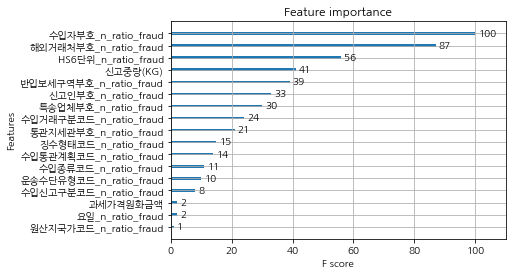

In [37]:
# plot feature importances

plot_importance(LogReg_pipeline)
# plt.savefig('./attention_histogram/multiclass/{0}/feature_importance_{1}'.format(version, seed), bbox_inches='tight')
plt.show()

# Generate meta-graph

### You should use "train_labeled_df" to generate meta-graph ("train_unlabeled_df" 도 가능)

In [38]:
[i.split('_')[0] for i in df.columns if 'ratio' in i]

['통관지세관부호',
 '요일',
 '신고인부호',
 '수입자부호',
 '수입종류코드',
 '수입통관계획코드',
 '수입신고구분코드',
 '수입거래구분코드',
 '징수형태코드',
 '운송수단유형코드',
 '적출국가코드',
 '원산지국가코드',
 'HS6단위',
 '해외거래처부호',
 '특송업체부호',
 '반입보세구역부호']

In [39]:
def find_interesting_category(df):
    ratio_column = [i.split("_")[0] for i in df.columns if 'ratio' in i]
    result_dict = {}
    for name in ratio_column:
        variance = df.groupby(name).var()['핵심우범여부'].mean()
        result_dict[name] = variance
    return result_dict

In [40]:
result_dict = find_interesting_category(train_labeled_df)
# result_dict = find_interesting_category(pd.concat([train_labeled_df, train_unlabeled_df]))

In [41]:
res = sorted(result_dict.items(), key=(lambda x: x[1]), reverse=False)
# category = [i for i, j in res[:4]]
# category = ['수입자부호', '해외거래처부호']
# category = [i for i, j in res]

In [42]:
category = ['신고인부호', '수입자부호', '적출국가코드', 'HS6단위']

In [43]:
# feature_importance = LogReg_pipeline.get_booster().get_score()
# category_sorted_by_FI = [key.split('_')[0] for key, value in sorted(feature_importance.items(), key=lambda item:item[1], reverse = True)
#                                 if 'ratio' in key] # get categories sorted by feature importance score
# category = category_sorted_by_FI[:4]
# category

In [44]:
## category // 활용한 방법 - 메소드 // 돌아가는데 걸린 시간 // precision과 recall

# result_logger.info('Category: [{0}]'.format(', '.join(category)))

In [45]:
# result_csv = open('./attention_log/multiclass/csv_{0}.csv'.format(version), 'a', encoding='utf-8-sig') # create csv file if it does not exists
# writer = csv.writer(result_csv)

# writer.writerow(['Category: [{0}]'.format(', '.join(category))])

# Generate groups

In [46]:
class Dataset(data.Dataset):
    def __init__(self, search_df, target_df, neighbor_k, category):
        self.neighbor_k = neighbor_k
        self.search_df = search_df
        self.target_df = target_df
        self.target_Y = self.target_df['핵심우범여부'].copy()
        
        self.category = category
        self.group_dict = {}
        
        ratio_column = [i for i in df.columns if 'ratio' in i]
        column_to_inspect = ['과세가격원화금액','신고중량(KG)','관세율']+ratio_column+['핵심우범여부']
        self.node_columns = column_to_inspect
        
        self.labeled_search_df = self.search_df[self.search_df['핵심우범여부'] != 0.5]
        self.unlabeled_search_df = self.search_df[self.search_df['핵심우범여부'] == 0.5]
        
        self.labeled_nested_dict = {}
        for cat in self.category:
            cat_dict = {}
            grouped_df = self.labeled_search_df.groupby(cat)
            for group_name, group in grouped_df:
                cat_dict[group_name] = group.index.to_list()
            self.labeled_nested_dict[cat] = cat_dict
            
        self.unlabeled_nested_dict = {}
        for cat in self.category:
            cat_dict = {}
            grouped_df = self.unlabeled_search_df.groupby(cat)
            for group_name, group in grouped_df:
                cat_dict[group_name] = group.index.to_list()
            self.unlabeled_nested_dict[cat] = cat_dict

    def __len__(self):
        return len(self.target_df)
    
    def __getitem__(self, idx: int):
        row = self.target_df.iloc[idx]
        t_id = row['신고번호']
        row_feature = torch.tensor(row[self.node_columns].to_numpy(dtype=float)).float()
        row_feature[-1] = 0.5
        row_target = self.target_Y.iloc[idx]
        
        neighbor_list = []
        for cat in self.category:
            labeled_cat_dict = self.labeled_nested_dict[cat]
            unlabeled_cat_dict = self.unlabeled_nested_dict[cat]     
            labeled_index = labeled_cat_dict.get(row[cat], [])
            unlabeled_index = unlabeled_cat_dict.get(row[cat], [])      
            if len(labeled_index) + len(unlabeled_index) > 0:
                if len(labeled_index) < self.neighbor_k:
                    labeled_neighbors = labeled_index
                    unlabeled_neighbors = np.random.choice(unlabeled_index, 
                                                           min(self.neighbor_k - len(labeled_neighbors), len(unlabeled_index)), 
                                                           replace=False).tolist()
                    neighbors = labeled_neighbors + unlabeled_neighbors
                else:
                    neighbors = np.random.choice(labeled_index, self.neighbor_k, replace=False).tolist()

                aggregated_neighbors = torch.tensor(self.search_df.loc[neighbors][self.node_columns].to_numpy()).float()

                if len(aggregated_neighbors) < self.neighbor_k:
                    diff = self.neighbor_k - len(aggregated_neighbors)
                    aggregated_neighbors = torch.cat((aggregated_neighbors, torch.zeros(diff, aggregated_neighbors.shape[1])))
            else:
                aggregated_neighbors = torch.zeros(self.neighbor_k, row_feature.shape[0])
            neighbor_list.append(aggregated_neighbors)

        neighbor_stack = torch.stack(neighbor_list, dim=0)
        return row_feature, neighbor_stack, row_target

# Define a model

In [47]:
class MLP(nn.Module):
    def __init__(self, input_dim=2048, hidden_size=4096, output_dim=128):
        super().__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size, bias=False),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, output_dim, bias=True))

    def forward(self, x):
        x = self.model(x)
        return x

In [95]:
class AttDetect(nn.Module):
    def __init__(self, input_dim, hidden_dim, category, nhead=8):
        super(AttDetect, self).__init__()    
        self.input_dim = input_dim
        self.dim = hidden_dim
        self.nhead = nhead
        self.category = category
        
        self.initEmbedding = MLP(self.input_dim, self.dim, self.dim)
        self.selfmha_list = nn.ModuleList()
        self.mha_list = nn.ModuleList()
        for cat in category:
            self.selfmha_list.append(nn.MultiheadAttention(self.dim, self.nhead, dropout=0.1))
            self.mha_list.append(nn.MultiheadAttention(self.dim, self.nhead, dropout=0.1))

        self.finall_addatt = AdditiveAttention(self.dim, self.dim)
        self.classifier = nn.Linear(self.dim, num_class)
        
        self.recons_layer = nn.Sequential(nn.Linear(self.dim, self.dim),
                                          nn.BatchNorm1d(self.dim),
                                          nn.ReLU(inplace=True),
                                          nn.Linear(self.dim, self.input_dim))
        
        self.recon_criterion = nn.MSELoss()
        self.criterion = nn.CrossEntropyLoss() # for multiclass
        
    def forward(self, row_feature, neighbor_stack, labels=None, recon_target=None, mask=None, attention=False):
        # n_kind(K): category 개수
        batch_sz, n_kind, n_neighbor, feature_dim = neighbor_stack.shape # [B, K, N, D]
        neighbor_stack = neighbor_stack.reshape(-1, feature_dim)
        
        query_embed = self.initEmbedding(row_feature) 
        neighbor_embed = self.initEmbedding(neighbor_stack)
        neighbor_embed = neighbor_embed.reshape(batch_sz, n_kind, n_neighbor, -1)
        neighbor_embed = neighbor_embed.permute(1, 0, 2, 3) # [K, B, N, D]
        
        neighbor_queryatt_list = []
        neighbor_attvec_list = []
        for i, neighbor_each in enumerate(neighbor_embed):
            neighbor_each = F.dropout(neighbor_each.permute(1, 0, 2), 0.1) # [N, B, D]
            neighbor_coatt, _ = self.selfmha_list[i](neighbor_each, neighbor_each, neighbor_each) # [N, B, D]
            neighbor_queryatt, neighbor_attvec = self.mha_list[i](query_embed.unsqueeze(0), neighbor_coatt, neighbor_coatt) # [1, B, D]
            neighbor_queryatt_list.append(neighbor_queryatt.squeeze()) # [B, D]
            neighbor_attvec_list.append(neighbor_attvec)
 
        neighbor_queryatt_mat = torch.stack(neighbor_queryatt_list) # [K, B, D]
        neighbor_queryatt_mat = neighbor_queryatt_mat.permute(1, 0, 2) # [B, K, D]
        
        final_repr, final_att = self.finall_addatt(torch.cat((neighbor_queryatt_mat, query_embed.unsqueeze(1)), dim=1)) # [B, K+1, D] -> [B, D]
        logit = self.classifier(final_repr).squeeze() # [B]

        # Get MSE loss by comparing masked part between reconstructed and original feature
        if recon_target != None and mask != None:
            mask_vec = torch.tensor(mask).to(final_repr.device)
            reconstructed = self.recons_layer(final_repr)  
            loss = self.recon_criterion(reconstructed * mask_vec, recon_target * mask_vec)
            return loss
        
        if labels != None:
            loss = self.criterion(logit, labels.long())
            return loss, F.softmax(logit)
        
        if attention:
            return F.softmax(logit), final_att, neighbor_attvec_list
        
        return F.softmax(logit)

In [84]:
neighbor_k = 50
#category = ['신고인부호', '수입자부호', '적출국가코드', 'HS6단위']

In [85]:
## MODEL Test
# print(category)
# model = AttDetect(train_sample.shape[0], 32, category)
# train_loader = data.DataLoader(train_ds, batch_size=4, num_workers=1, shuffle=False, drop_last=False)
# batch = iter(train_loader).next()
# row_feature, neighbor_stack, row_target = batch
# model(row_feature, neighbor_stack, row_target)

# Pretraining

In [86]:
class PretrainDataset(data.Dataset):
    def __init__(self, search_df, target_df, neighbor_k, category, p_m=0.3):
        self.p_m = p_m
        self.neighbor_k = neighbor_k
        self.search_df = search_df
        self.target_df = target_df
        self.target_Y = self.target_df['핵심우범여부'].copy()
        
        self.category = category
        self.group_dict = {}
        
        ratio_column = [i for i in df.columns if 'ratio' in i]
        column_to_inspect = ['과세가격원화금액','신고중량(KG)','관세율']+ratio_column+['핵심우범여부']
        self.node_columns = column_to_inspect
        
        self.labeled_search_df = self.search_df[self.search_df['핵심우범여부'] != 0.5]
        self.unlabeled_search_df = self.search_df[self.search_df['핵심우범여부'] == 0.5]
        
        self.labeled_nested_dict = {}
        for cat in self.category:
            cat_dict = {}
            grouped_df = self.labeled_search_df.groupby(cat)
            for group_name, group in grouped_df:
                cat_dict[group_name] = group.index.to_list()
            self.labeled_nested_dict[cat] = cat_dict
            
        self.unlabeled_nested_dict = {}
        for cat in self.category:
            cat_dict = {}
            grouped_df = self.unlabeled_search_df.groupby(cat)
            for group_name, group in grouped_df:
                cat_dict[group_name] = group.index.to_list()
            self.unlabeled_nested_dict[cat] = cat_dict

    def __len__(self):
        return len(self.target_df)
    
    def __getitem__(self, idx: int):
        row = self.target_df.iloc[idx]
        t_id = row['신고번호']
        row_feature = torch.tensor(row[self.node_columns].to_numpy(dtype=float)).float() # row feature: colums_to_inspect에 해당하는 dataframe
        row_feature[-1] = 0.5
        row_target = self.target_Y.iloc[idx]
        
        neighbor_list = []
        for cat in self.category:
            labeled_cat_dict = self.labeled_nested_dict[cat]
            unlabeled_cat_dict = self.unlabeled_nested_dict[cat]     
            labeled_index = labeled_cat_dict.get(row[cat], [])
            unlabeled_index = unlabeled_cat_dict.get(row[cat], [])      
            if len(labeled_index) + len(unlabeled_index) > 0:
                if len(labeled_index) < self.neighbor_k:
                    labeled_neighbors = labeled_index
                    unlabeled_neighbors = np.random.choice(unlabeled_index, 
                                                           min(self.neighbor_k - len(labeled_neighbors), len(unlabeled_index)), 
                                                           replace=False).tolist()
                    neighbors = labeled_neighbors + unlabeled_neighbors
                else:
                    neighbors = np.random.choice(labeled_index, self.neighbor_k, replace=False).tolist()

                aggregated_neighbors = torch.tensor(self.search_df.loc[neighbors][self.node_columns].to_numpy()).float()

                if len(aggregated_neighbors) < self.neighbor_k:
                    diff = self.neighbor_k - len(aggregated_neighbors)
                    aggregated_neighbors = torch.cat((aggregated_neighbors, torch.zeros(diff, aggregated_neighbors.shape[1])))
            else:
                aggregated_neighbors = torch.zeros(self.neighbor_k, row_feature.shape[0])
            neighbor_list.append(aggregated_neighbors)

        neighbor_stack = torch.stack(neighbor_list, dim=0)
        
        # Generate random mask
        mask_num = int(self.p_m * len(row_feature))
        mask_vector = np.ones(len(row_feature))
        mask_vector[:mask_num] = 0
        np.random.shuffle(mask_vector)
        
        
        return (row_feature * mask_vector).float(), neighbor_stack, row_feature, 1-mask_vector

In [87]:
class PretrainModel(LightningModule):
    def __init__(self, train_ds, batch_size, input_dim=20, hidden_dim=32, category=None):
        super(PretrainModel, self).__init__()
        self.model = AttDetect(input_dim, hidden_dim, category)
        self.category = category
        self.train_ds = train_ds
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return data.DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=12, shuffle=True, drop_last=False)

    def forward(self):
        return None
    
    def training_step(self, batch, batch_idx):        
        row_feature, neighbor_stack, row_target, mask = batch
        loss = self.model(row_feature, neighbor_stack, recon_target=row_target, mask=mask)
        return {'loss': loss}
    
    def training_epoch_end(self, outputs):
        loss_mean = torch.stack([x['loss'] for x in outputs]).mean()
        self.log("train_loss", loss_mean)
    
    def configure_optimizers(self):
        optimizer = RangerLars(self.parameters(), lr=0.01, weight_decay=0.0001)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.99)
        return [optimizer], [scheduler]

In [88]:
train_all_df = pd.concat([train_labeled_df, train_unlabeled_df])
pretrain_ds = PretrainDataset(train_all_df, train_all_df, neighbor_k, category)

In [89]:
# model config
input_dim = 20
hidden_size = 32
batch_size = 128

pretrain_predictor = PretrainModel(pretrain_ds, batch_size, input_dim, hidden_size, category)
logger = TensorBoardLogger("ssl_pretrain_exp",name="Kdata")

trainer = Trainer(gpus=[0], max_epochs=1)
trainer.fit(pretrain_predictor)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type      | Params
------------------------------------
0 | model | AttDetect | 38.5 K
------------------------------------
38.5 K    Trainable params
0         Non-trainable params
38.5 K    Total params
0.154     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

# Training

In [90]:
class MainModel(LightningModule):
    def __init__(self, train_ds, valid_ds, test_ds, batch_size, input_dim=20, hidden_dim=32, category=None):
        super(MainModel, self).__init__()
        self.model = AttDetect(input_dim, hidden_dim, category)
        self.category = category
        self.train_ds = train_ds
        self.val_ds = valid_ds
        self.test_ds = test_ds
        self.batch_size = batch_size
        
    def load_fromPretrain(self,path):
        self.model.load_from_checkpoint(path)
        
    def load_state(self, pretrained_model):
        self.model.load_state_dict(pretrained_model.state_dict())
        
    def train_dataloader(self):
        return data.DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=12, shuffle=True, drop_last=False)

    def val_dataloader(self):
        return data.DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=12, shuffle=False, drop_last=False)
    
    def test_dataloader(self):
        return data.DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=12, shuffle=False, drop_last=False)

    def forward(self):
        return None
    
    def training_step(self, batch, batch_idx):        
        row_feature, neighbor_stack, row_target = batch
        loss, logits = self.model(row_feature, neighbor_stack, row_target)
        return {'loss': loss}
    
    def training_epoch_end(self, outputs):
        loss_mean = torch.stack([x['loss'] for x in outputs]).mean()
        self.log("train_loss", loss_mean)
    
    def validation_step(self, batch, batch_idx):
        row_feature, neighbor_stack, row_target = batch
        with torch.no_grad():
            valid_loss, logits = self.model(row_feature, neighbor_stack, row_target)
        self.log('val_loss', valid_loss, on_step=True, on_epoch=True, sync_dist=True)         
        return logits
    
    def validation_epoch_end(self, outputs):
        predictions = torch.cat(outputs).detach().cpu().numpy().ravel()
        predictions = predictions.reshape(-1,3)
        
        f, pr, re = torch_metrics(np.array(predictions), np.argmax(predictions, axis = 1), self.val_ds.target_Y.astype(int).to_numpy())
        f1_top = np.mean(f)
        self.log("F1-top",f1_top)
        performance = [*f, *pr, *re]
        name_performance = ["F1@1","F1@2","F1@5","F1@10","Pr@1","Pr@2","Pr@5","Pr@10",
                            "Re@1","Re@2","Re@5","Re@10"]
        name_performance = ["Val/"+i for i in name_performance]
        tensorboard_logs = dict(zip(name_performance,performance))
        return {"Val/F1-top":f1_top, "log":tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
    
    def test_epoch_end(self,outputs):
        predictions = torch.cat(outputs).detach().cpu().numpy().ravel()
        predictions = predictions.reshape(-1,3)
        f, pr, re = torch_metrics(np.array(predictions), np.argmax(predictions, axis = 1), self.test_ds.target_Y.astype(int).to_numpy())
        f1_top = np.mean(f)
        self.log("F1-top",f1_top)
        performance = [*f, *pr, *re]
        name_performance = ["F1@1","F1@2","F1@5","F1@10","Pr@1","Pr@2","Pr@5","Pr@10",
                            "Re@1","Re@2","Re@5","Re@10"]
        name_performance = ["Val/"+i for i in name_performance]
        tensorboard_logs = dict(zip(name_performance,performance))
        return {"Val/F1-top":f1_top, "log":tensorboard_logs}
    
    def configure_optimizers(self):
        optimizer = RangerLars(self.parameters(), lr=0.01, weight_decay=0.0001)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.99)
        return [optimizer], [scheduler]

In [91]:
train_ds = Dataset(train_all_df, train_labeled_df, neighbor_k, category)
valid_ds = Dataset(train_all_df, valid_df, neighbor_k, category)

train_valid_all_df = pd.concat([train_all_df, valid_df])
test_ds = Dataset(train_valid_all_df, test_df, neighbor_k, category)

In [92]:
# result_logger = get_logger()
# result_logger.info('<Train>')
# writer.writerow(['Train'])

In [96]:
# model config
input_dim = 20
hidden_size = 32
batch_size = 64

predictor = MainModel(train_ds, valid_ds, test_ds, batch_size, input_dim, hidden_size, category)
predictor.load_state(pretrain_predictor.model)

logger = TensorBoardLogger("ssl_exp",name="Kdata")
checkpoint_callback = ModelCheckpoint(
    monitor='F1-top',    
    dirpath='./saved_model',
    filename='Analysis-Tdata5-{F1-top:.4f}',
    save_top_k=1,
    mode='max',
)

trainer = Trainer(gpus=[0], max_epochs=3,
                 num_sanity_val_steps=0,
                  check_val_every_n_epoch=1,  
                  callbacks=[checkpoint_callback, EarlyStopping(monitor='F1-top')])
trainer.fit(predictor)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type      | Params
------------------------------------
0 | model | AttDetect | 38.5 K
------------------------------------
38.5 K    Trainable params
0         Non-trainable params
38.5 K    Total params
0.154     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Checking top 1% suspicious transactions: 200
Precision: 0.3600, Recall: 0.0302
Checking top 2% suspicious transactions: 400
Precision: 0.3400, Recall: 0.0571
Checking top 5% suspicious transactions: 1000
Precision: 0.3020, Recall: 0.1267
Checking top 10% suspicious transactions: 2000
Precision: 0.2535, Recall: 0.2128


Validating: 0it [00:00, ?it/s]

Checking top 1% suspicious transactions: 200
Precision: 0.2650, Recall: 0.0222
Checking top 2% suspicious transactions: 400
Precision: 0.2600, Recall: 0.0436
Checking top 5% suspicious transactions: 1000
Precision: 0.2330, Recall: 0.0978
Checking top 10% suspicious transactions: 2000
Precision: 0.2095, Recall: 0.1758


Validating: 0it [00:00, ?it/s]

Checking top 1% suspicious transactions: 200
Precision: 0.3450, Recall: 0.0290
Checking top 2% suspicious transactions: 400
Precision: 0.2975, Recall: 0.0499
Checking top 5% suspicious transactions: 1000
Precision: 0.2750, Recall: 0.1154
Checking top 10% suspicious transactions: 2000
Precision: 0.2360, Recall: 0.1981


In [70]:
# result_logger.info('<Test>')
# writer.writerow(['Test'])

In [97]:
test_result = trainer.test()
# result_logger.info(str(test_result))
# writer.writerows([[key, value] for key,value in test_result[0].items()])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

Checking top 1% suspicious transactions: 200
Precision: 0.3600, Recall: 0.0296
Checking top 2% suspicious transactions: 400
Precision: 0.3325, Recall: 0.0547
Checking top 5% suspicious transactions: 1000
Precision: 0.3170, Recall: 0.1305
Checking top 10% suspicious transactions: 2000
Precision: 0.2845, Recall: 0.2342
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'F1-top': 0.1476175776413728,
 'val_loss': 0.6559306979179382,
 'val_loss_epoch': 1.1468844413757324}
--------------------------------------------------------------------------------


# Analysis

In [61]:
test_loader = predictor.test_dataloader()

In [62]:
predictor.model.cuda()

AttDetect(
  (initEmbedding): MLP(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=32, bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (selfmha_list): ModuleList(
    (0): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=32, out_features=32, bias=True)
    )
    (1): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=32, out_features=32, bias=True)
    )
    (2): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=32, out_features=32, bias=True)
    )
    (3): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=32, out_features=32, bias=True)
    )
  )
  (mha_list): ModuleList(
    (0): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=32, out_features=32, bias=True)
    )
    (1): MultiheadAttention(
      (out_proj): _LinearWithB

In [63]:
final_att_list = []
final_neighbor_attvec_list = []
row_target_list = []
for i, batch in enumerate(tqdm(test_loader)):
    row_feature, neighbor_stack, row_target = batch
    row_feature = row_feature.cuda()
    neighbor_stack = neighbor_stack.cuda()
    row_target = row_target.cuda()
    
    with torch.no_grad():
        logits, final_att, neighbor_attvec_list = predictor.model(row_feature, neighbor_stack, attention=True)
        
    final_att_list.append(final_att.detach().cpu())
    final_neighbor_attvec_list.append(neighbor_attvec_list)
    row_target_list.append(row_target.detach().cpu())  

100%|██████████| 313/313 [00:09<00:00, 32.50it/s]


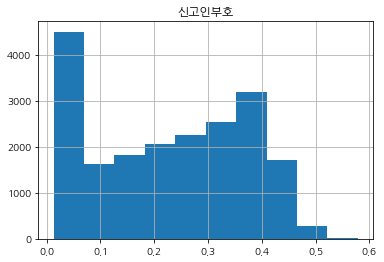

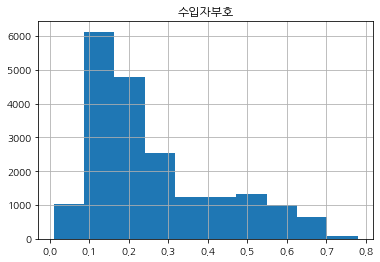

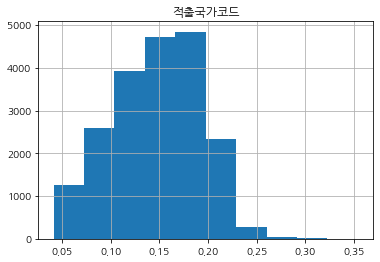

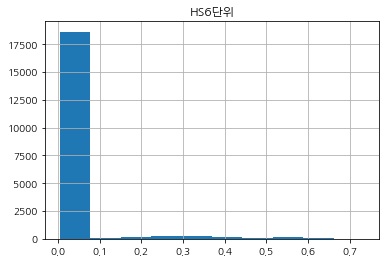

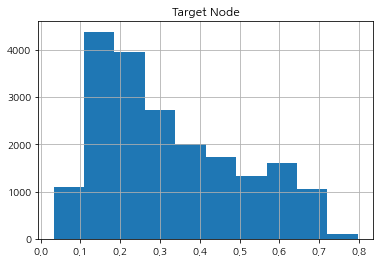

In [64]:
final_att_mat = torch.cat(final_att_list, dim=0)

for i in range(len(category)+1):
    plt.figure()
    pd.Series(final_att_mat.numpy()[:, i]).hist() 
    if i==len(category):
        plt.title('Target Node')
        # plt.savefig('./attention_histogram/multiclass/{0}/all/seed{3}_{1}_{2}'.format(version, i, 'TargetNode', seed))
    else:
        plt.title(category[i])
        # plt.savefig('./attention_histogram/multiclass/{0}/all/seed{3}_{1}_{2}'.format(version, i, category[i], seed))

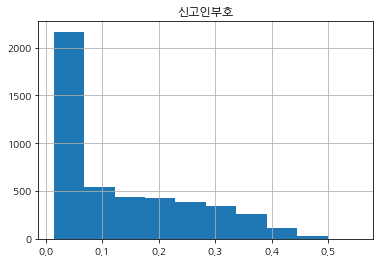

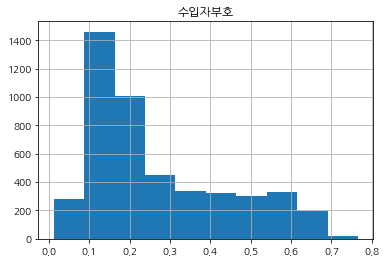

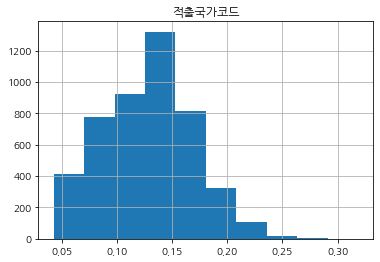

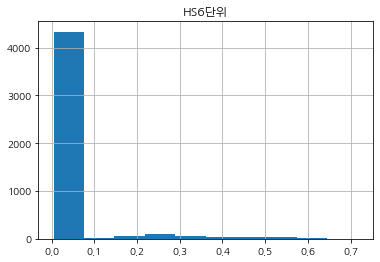

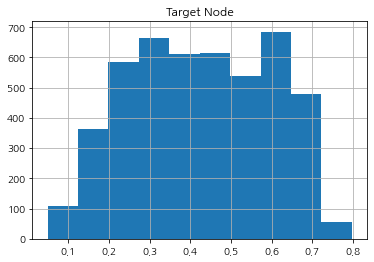

In [65]:
total_target = torch.cat(row_target_list, dim=0)
illegal_mat = final_att_mat[total_target.nonzero().squeeze(), :]
for i in range(len(category)+1):
    plt.figure()
    pd.Series(illegal_mat.numpy()[:, i]).hist() 
    if i==len(category):
        plt.title('Target Node')
        # plt.savefig('./attention_histogram/multiclass/{0}/illegal/seed{3}_{1}_{2}'.format(version, i, 'TargetNode', seed))
    else:
        plt.title(category[i])
        # plt.savefig('./attention_histogram/multiclass/{0}/illegal/seed{3}_{1}_{2}'.format(version, i, category[i], seed))

In [66]:
# result_csv.close()